# Лабораторная работа 4 "Восстановление плотности и семплирование"
Выполнил студент группы М8О-114СВ-24, Терентьев И.В.

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

In [124]:
np.random.seed(0)
X, _ = make_blobs(n_samples=300, centers=2, random_state=0, n_features=1)

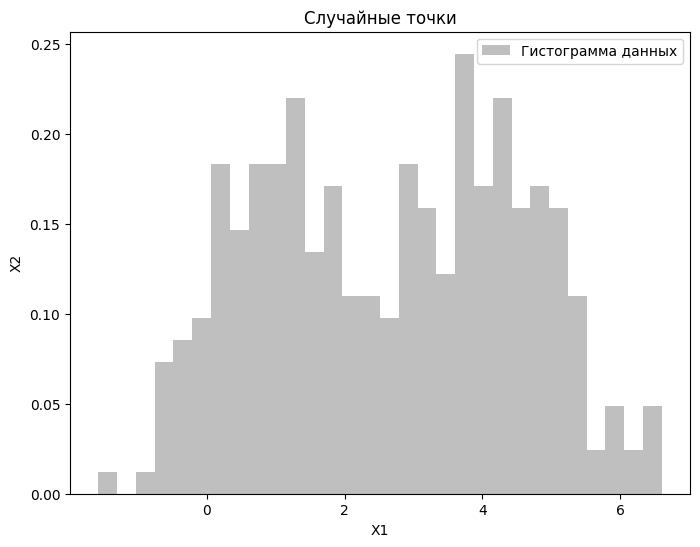

In [125]:
plt.figure(figsize=(8, 6))
plt.hist(X, bins=30, density=True, alpha=0.5, color='gray', label='Гистограмма данных')
plt.title('Случайные точки')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

<h1>Восстановление плотности</h1>

In [127]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(X)
x_d = np.linspace(-2, 7, 100)
dens_kde = np.exp(kde.score_samples(x_d[:, None]))

In [128]:
gmm = GaussianMixture(2, random_state=0).fit(X)
x_gmm = np.linspace(-2, 7, 100)
dens_gmm = np.exp(gmm.score_samples(x_gmm[:, None]))

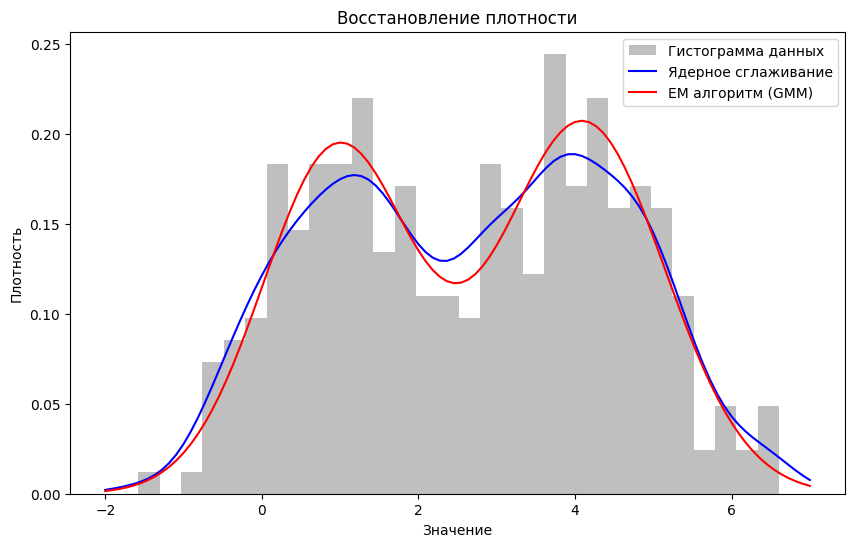

In [129]:
plt.figure(figsize=(10, 6))
plt.hist(X, bins=30, density=True, alpha=0.5, color='gray', label='Гистограмма данных')
plt.plot(x_d, dens_kde, color='blue', label='Ядерное сглаживание')
plt.plot(x_gmm, dens_gmm, color='red', label='EM алгоритм (GMM)')
plt.title('Восстановление плотности')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()
plt.show()

<h1>Сэмплирование</h1>

In [130]:
class MetropolisHastings():
    def __init__(self, log_target_distribution_prob, stepsize=2):
        self.target_distribution_prob = log_target_distribution_prob
        self.samples = []
        self.stepsize = stepsize
        self.proposal_distribution = lambda x: np.random.uniform(low=x - 0.5*self.stepsize, high=x + 0.5 * self.stepsize, size=x.shape)

    def fit(self, num_samples, initial_state):
        current_state = initial_state
        for _ in range(num_samples):
            proposed_state = self.propose_state(current_state)
            acceptance_ratio = self.calculate_acceptance_ratio(current_state, proposed_state)
            if np.random.rand() < acceptance_ratio:
                current_state = proposed_state

            self.samples.append(current_state)
        return self

    def propose_state(self, current_state):
        proposed_state = self.proposal_distribution(current_state)
        return proposed_state

    def calculate_acceptance_ratio(self, current_state, proposed_state):
        log_cur_state = self.target_distribution_prob(current_state)
        log_prop_state = self.target_distribution_prob(proposed_state)
        return min(1, np.exp(log_prop_state - log_cur_state)) # Ядро перехода - критерий приемлемости Метрополиса

    def get_samples(self):
        return np.array(self.samples)

In [131]:
class Gibbs:
    def __init__(self):
        self.samples = []

    def fit(self, num_samples, initial_state):
        self.samples.append(initial_state)

        for _ in range(num_samples - 1):
            current_sample = self.samples[-1]
            new_sample = current_sample.copy()
            for i in range(len(new_sample)):
                i_current = self.conditional_distribution(current_sample[i])
                new_sample[i] = i_current
            self.samples.append(current_sample.copy())
        return self

    def get_samples(self):
        return np.array(self.samples)

In [132]:
initial_state = np.array([0])
target_dist = lambda x: gmm.score_samples([x])  # Целевая плотность

mh = MetropolisHastings(target_dist)

num_samples = 5000
samples_mh = mh.fit(num_samples, initial_state).get_samples()

In [133]:
# Метод Гиббса
#initial_state = np.array([0])

#num_samples = 5000

#gibbs = Gibbs()

#samples_gibbs = gibbs.fit(num_samples, initial_state).get_samples()

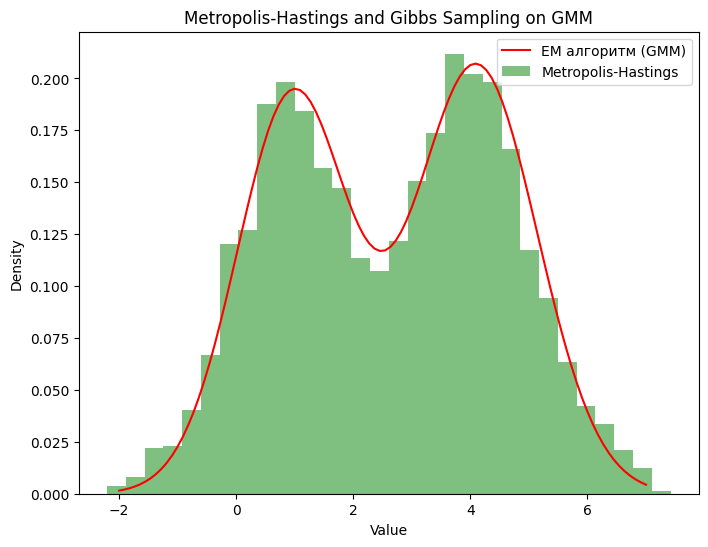

In [134]:
plt.figure(figsize=(8, 6))
plt.plot(x_gmm, dens_gmm, color='red', label='EM алгоритм (GMM)')
plt.hist(samples_mh, bins=30, density=True, alpha=0.5, label='Metropolis-Hastings', color='green')
#plt.hist(samples_gibbs, bins=30, density=True, alpha=0.5, label='Gibbs Sampling', color='orange')
plt.title('Metropolis-Hastings and Gibbs Sampling on GMM')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [139]:
initial_state = np.array([0])
target_dist = lambda x: kde.score_samples([x])

mh = MetropolisHastings(target_dist)

num_samples = 5000
samples_mh = mh.fit(num_samples, initial_state).get_samples()

In [140]:
# Метод Гиббса
#initial_state = 0
#target_dist = lambda x: kde.score_samples(np.array([x]).reshape(1, -1))  # Целевая плотность

#num_samples = 5000
#dist_data = gmm.sample(num_samples)[0].ravel()
#gibbs = Gibbs(dist_data, target_dist)

#samples_gibbs = gibbs.fit(num_samples, initial_state).get_samples()

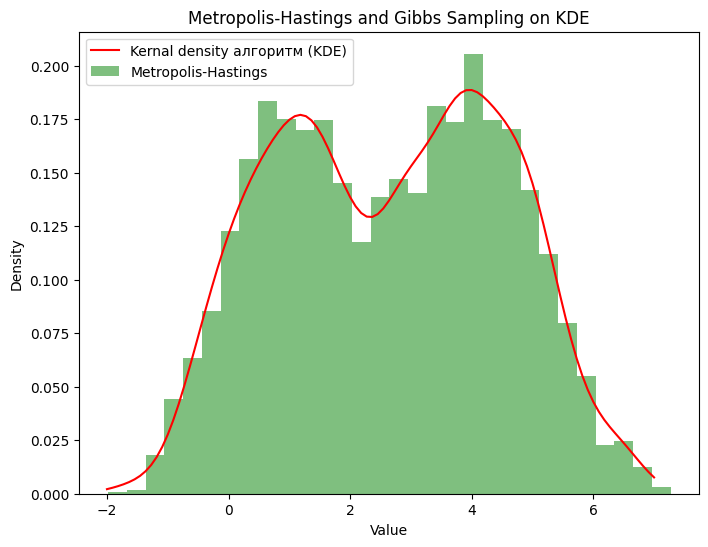

In [141]:
plt.figure(figsize=(8, 6))
plt.plot(x_d, dens_kde, color='red', label='Kernal density алгоритм (KDE)')
plt.hist(samples_mh, bins=30, density=True, alpha=0.5, label='Metropolis-Hastings', color='green')
#plt.hist(samples_gibbs, bins=30, density=True, alpha=0.5, label='Gibbs Sampling', color='orange')
plt.title('Metropolis-Hastings and Gibbs Sampling on KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

<H1>Визуализация точек, сравнение вероятностными методами и KL-дивергенции</H1>

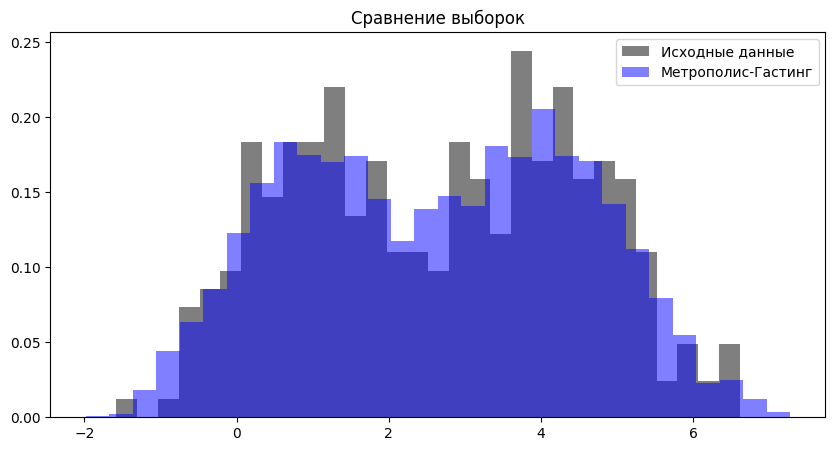

In [142]:
plt.figure(figsize=(10, 5))
plt.hist(X, bins=30, density=True, alpha=0.5, color='black', label='Исходные данные')
plt.hist(samples_mh, bins=30, density=True, alpha=0.5, color='blue', label='Метрополис-Гастинг')
#plt.hist(samples_gibbs, bins=30, density=True, alpha=0.5, color='red', label='Гиббс')
plt.legend()
plt.title("Сравнение выборок")
plt.show()

<h1>Случайное блуждание для трёхмерных точек</h1>

In [87]:
np.random.seed(0)
X, _ = make_blobs(n_samples=100, centers=4, random_state=0, n_features=3)

In [88]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
x = np.linspace(-5, 10, 100)
y = np.linspace(-5, 10, 100)
z = np.linspace(-5, 10, 100)
X, Y, Z = np.meshgrid(x, y, z)
data = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

log_dens = kde.score_samples(data)

In [98]:
initial_state = np.array([0, 0, 0])
target_dist = lambda x: kde.score_samples([x])
mh = MetropolisHastings(target_dist)

num_samples = 1000
samples_mh_3d = mh.fit(num_samples, initial_state).get_samples()

In [101]:
def visualize_path(points):
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, y, z, marker='o', markersize=1, linestyle='-', color='b', alpha=0.6)

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Случайное блуждание')

    plt.show()

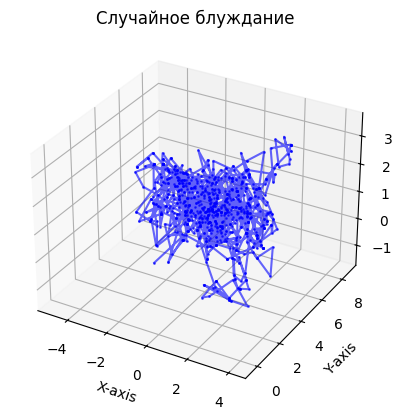

In [102]:
visualize_path(samples_mh_3d)